In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-darkgrid")

# 1ra Etapa: Análisis exploratorio de los datos

## Tabla Pedidos

Esta tabla contiene los registros históricos de los pedidos realizados por los clientes en una fecha determinada. Aunque los datos no pertenecen a la cadena de suministro actual, nos sirve como base para armar las restricciones de optimización de la misma.

In [591]:
pedidos = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "OrderList")

pedidos.columns = ["Pedido", "Fecha", "Puerto de origen", "Transportista", "TPT", "Nivel de servicio", "Envío adelantado [días]", 
                   "Envío tardío [días]", "Cliente", "Producto", "Planta", "Puerto de destino", "Items", "Peso [kg/item]"]

In [592]:
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9215 entries, 0 to 9214
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Pedido                   9215 non-null   float64       
 1   Fecha                    9215 non-null   datetime64[ns]
 2   Puerto de origen         9215 non-null   object        
 3   Transportista            9215 non-null   object        
 4   TPT                      9215 non-null   int64         
 5   Nivel de servicio        9215 non-null   object        
 6   Envío adelantado [días]  9215 non-null   int64         
 7   Envío tardío [días]      9215 non-null   int64         
 8   Cliente                  9215 non-null   object        
 9   Producto                 9215 non-null   int64         
 10  Planta                   9215 non-null   object        
 11  Puerto de destino        9215 non-null   object        
 12  Items                    9215 non-

*¿La tabla contiene filas duplicadas?*

In [593]:
pedidos.duplicated().any()

False

In [594]:
pedidos = pedidos.astype({"Pedido": int})
pedidos[["Puerto de origen", "Planta", "Puerto de destino"]] = pedidos[["Puerto de origen", "Planta", 
                                                                        "Puerto de destino"]].replace({"[^\d.]": ""}, regex = True).astype(int)

pedidos.head()

,Pedido,Fecha,Puerto de origen,Transportista,TPT,Nivel de servicio,Envío adelantado [días],Envío tardío [días],Cliente,Producto,Planta,Puerto de destino,Items,Peso [kg/item]
0,1447296446,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,808,14.30
1,1447158014,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,3188,87.94
2,1447138898,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,2331,61.20
3,1447363527,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,847,16.16
4,1447363980,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,2163,52.34


*¿Cuántas filas y columnas tiene esta tabla? (N° filas, N° columnas)*

In [595]:
pedidos.shape

(9215, 14)

*¿Cuándo se realizaron los pedidos?*

In [596]:
d = pedidos["Fecha"].unique().astype("datetime64[D]").astype(str)
d[0]

'2013-05-26'

*¿Cuál es el total de pedidos?*

In [597]:
pedidos.shape[0]

9215

*¿Cuántos pedidos fueron solicitados por cada conjunto Planta, Puerto de origen y Puerto de destino?*

In [598]:
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", 
                                      "Puerto de destino"]).agg({"Pedido": "size"}).rename(columns = {"Pedido": "Recuento de Pedidos"})

total = pedidos_agrup["Recuento de Pedidos"].sum()
pedidos_agrup["%"] = pedidos_agrup["Recuento de Pedidos"].apply(lambda x: x / total * 100)

pedidos_agrup.round(2)

,,,Recuento de Pedidos,%
Planta,Puerto de origen,Puerto de destino,,
3,4,9,8541,92.69
4,5,9,1,0.01
8,4,9,102,1.11
9,4,9,12,0.13
12,4,9,300,3.26
13,4,9,86,0.93
16,9,9,173,1.88


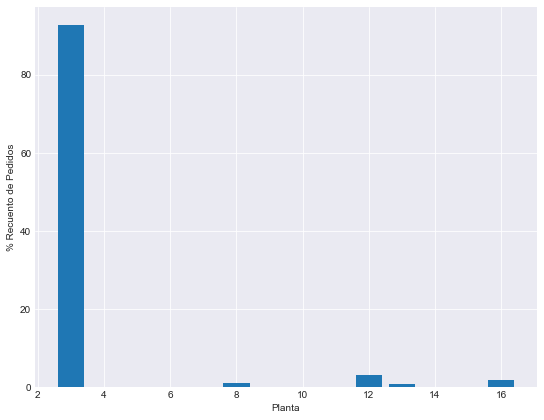

In [599]:
plt.figure(figsize = (9, 7))
plt.bar(x = pedidos_agrup.index.levels[0], height = pedidos_agrup["%"])
plt.xlabel("Planta")
plt.ylabel("% Recuento de Pedidos");

*¿Cuántos items fueron solicitados por cada conjunto Planta, Puerto de origen y Puerto de destino?*

In [600]:
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Items": ["min", "mean", "max", "std", "sum"]})

total = pedidos_agrup[("Items", "sum")].sum()
pedidos_agrup[("Items", "%")] = pedidos_agrup[("Items", "sum")].apply(lambda x: x / total * 100)

pedidos_agrup.round(2)

Items                              \
                                            min      mean     max       std   
Planta Puerto de origen Puerto de destino                                     
3      4                9                   235   3349.91  561847  16525.97   
4      5                9                   348    348.00     348       NaN   
8      4                9                   684   2715.76    5680   1504.06   
9      4                9                  2301  18652.50  101069  28877.08   
12     4                9                   236    373.33    1321    169.36   
13     4                9                   240    504.41    5244    609.10   
16     9                9                   280   1416.95    4464   1121.49   

                                                            
                                                sum      %  
Planta Puerto de origen Puerto de destino                   
3      4                9                  28611617  96.94  
4      5                9                       348   0.00  
8      4                9                    277008   0.94  
9      4                9                    223830   0.76  
12     4                9                    112000   0.38  
13     4                9                     43379   0.15  
16     9                9                    245133   0.83

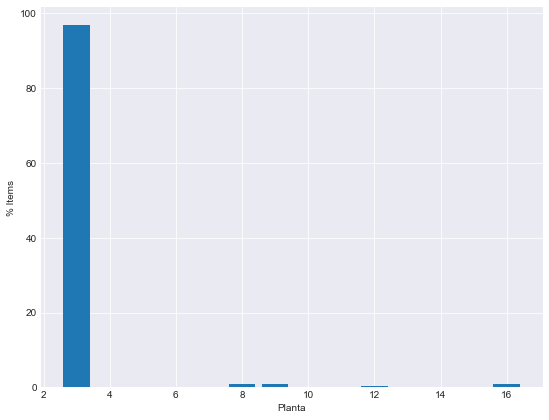

In [601]:
plt.figure(figsize = (9, 7))
plt.bar(x = pedidos_agrup.index.levels[0], height = pedidos_agrup[("Items", "%")])
plt.xlabel("Planta")
plt.ylabel("% Items");

*Estadística descriptiva de Peso [kg/items] por cada conjunto Planta, Puerto de origen y Puerto de destino*

In [602]:
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Peso [kg/item]": ["min", "mean", "max", "std", "sum"]})

total = pedidos_agrup[("Peso [kg/item]", "sum")].sum()
pedidos_agrup[("Peso [kg/item]", "%")] = pedidos_agrup[("Peso [kg/item]", "sum")].apply(lambda x: x / total * 100)

pedidos_agrup.round(2)

Peso [kg/item]                   \
                                                     min    mean      max   
Planta Puerto de origen Puerto de destino                                   
3      4                9                           0.00   15.86  1356.76   
4      5                9                           2.10    2.10     2.10   
8      4                9                           2.29   14.50    43.64   
9      4                9                           5.35   33.86   171.92   
12     4                9                           0.26   27.16   325.96   
13     4                9                           0.35   63.12   946.50   
16     9                9                           0.61  185.94  2338.41   

                                                                     
                                              std        sum      %  
Planta Puerto de origen Puerto de destino                            
3      4                9                   50.20  135486.51  73.99  
4      5                9                     NaN       2.10   0.00  
8      4                9                   10.37    1478.79   0.81  
9      4                9                   48.35     406.36   0.22  
12     4                9                   52.33    8147.43   4.45  
13     4                9                  127.13    5428.39   2.96  
16     9                9                  264.06   32168.01  17.57

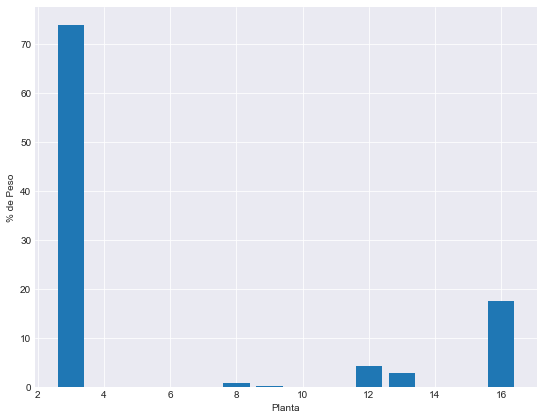

In [603]:
plt.figure(figsize = (9, 7))
plt.bar(x = pedidos_agrup.index.levels[0], height = pedidos_agrup[("Peso [kg/item]", "%")])
plt.xlabel("Planta")
plt.ylabel("% de Peso");

*¿Hay alguna correlación entre Peso [kg/items] e Items?*

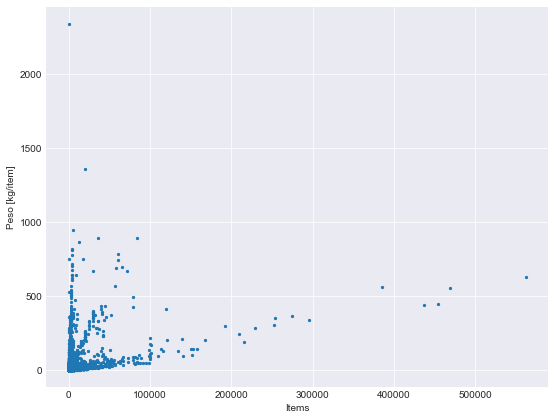

In [604]:
plt.figure(figsize = (9, 7))
plt.scatter(pedidos["Items"], pedidos["Peso [kg/item]"], s = 5)
plt.xlabel("Items")
plt.ylabel("Peso [kg/item]");

In [605]:
from scipy.stats import pearsonr 
r2, pvalue = pearsonr(x = pedidos["Items"], y = pedidos["Peso [kg/item]"])

round(r2, 3)

0.345